In [1]:
import numpy as np
#import seaborn as sns
#import matplotlib.pyplot as plt
import csv
#import networkx as nx
import pickle
from scipy import stats

import sys
sys.path.insert(1, '../../')
from utils import *

In [2]:
#dataset = 'hospital'
#dataset = 'high_school'
#dataset = 'conference'
#dataset = 'workplace'
dataset = 'pr_school'

In [3]:
weighted = True

In [4]:
mu = 0.1

if dataset == 'hospital':
    beta_betaT_range = [(0.2,0.8),(0.6,0.8),(0.06,10),(0.1,10),(0.3,10),(0.15,5),(0.3,5),(0.4,7.5),(0.05,15),(0.05,19)]
#elif dataset == 'high_school':
#    beta_betaT_range = [(0.7,5),(0.9,5),(0.7,7),(1,7),(0.7,1),(1,1)]
elif dataset == 'workplace':   
    beta_betaT_range = [#(0.5,6),
                        (0.5,7),
                        (0.4,7.3),
                        (0.3,6.5),
                        (0.25,6.5),
                        (0.25,7),
                        (0.2,7),
                        (0.2,7.3)]
elif dataset == 'conference':
    beta_betaT_range = [#(1,12),
                        #(0.9,12),
                        (0.8,12),
                        (0.7,12),
                        (0.6,12),
                        (0.5,12),
                        (0.4,12),
                        (0.4,10),
                        (0.3,12)]
elif dataset == 'pr_school':
    beta_betaT_range = [(0.07,7),
                        (0.1,7),
                        (0.1,5),
                        (0.2,7),
                        (0.15,5),
                        (0.2,5),
                        (0.2,3),
                        (0.2,1),
                        ]

# Load C and obtain r and s:

C is an array of weights, I need to put it in a matrix shape to compute r and s

In [5]:
def obtain_r_s_indices(C,edgelist):
    # put C in dict:
    C_dict = {}
    n = 0
    for edge in edgelist:
        C_dict[tuple(edge)] = C[n]
        C_dict[tuple(edge[::-1])] = C[n+1]
        n += 2
    # verify:
    if list(C_dict.values()) != list(C):
        print('error')
    nb_nodes = max(np.unique(list(C_dict.keys()))) + 1
    # put C_dict in matrix:
    C_mat = np.zeros((nb_nodes,nb_nodes))
    for link in C_dict:
        C_mat[link[0],link[1]] = C_dict[link]

    # receiver index:
    r = C_mat.sum(axis=0) # somma di ogni colonna
    # spreader index:
    s = C_mat.sum(axis=1) # somma di ogni riga

    return r, s

In [6]:
with open('../../data/pairwise/' + dataset + '_strength_edgelist_pairwise_sorted.pkl', 'rb') as f:
    edgelist = pickle.load(f)

In [7]:
r_list = []
s_list = []
for (beta,betaT) in beta_betaT_range:
    filename = "results/inf_treeSIR/CL_mean_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.2f_init_1.csv"%(dataset,beta,betaT,mu)
    CL = load_C_mean(filename)
    filename = "results/inf_treeSIR/CT_mean_weighted_%s_beta_%.3f_betaT_%.3f_mu_%.2f_init_1.csv"%(dataset,beta,betaT,mu)
    CT = load_C_mean(filename)
    C = CL + CT
    # verify:
    if 2*len(edgelist) != len(C):
        print('errore')
    r, s = obtain_r_s_indices(C,edgelist)
    r_list.append(r)
    s_list.append(s)
    

In [8]:
#r_list[0]

# Cosine similarity

### Receiver index

In [9]:
sim_r = np.full((len(beta_betaT_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_betaT_range)-1):
    for j in range(i+1,len(beta_betaT_range)):
        sim_r[i,j] = cos_sim(r_list[i],r_list[j] )

0.9888553098589898 0.9995708739114701
../figs/simplicial_cos_sim_receiver_pr_school_mu_0.10.pdf.pdf


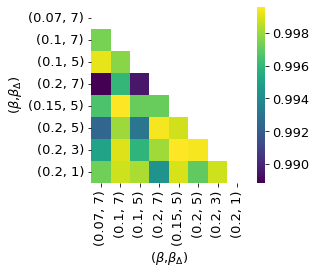

In [19]:
title='$r_i$ cosine sim.'
figname = '../figs/receiver_cos_sim_%s_mu_%.2f.pdf'%(dataset,mu)
plot_sim(sim_r, 
         mu, 
         beta_betaT_range,
         r'($\beta$,$\beta_{\Delta}$)',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

### Spreader index

In [11]:
sim_s = np.full((len(beta_betaT_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_betaT_range)-1):
    for j in range(i+1,len(beta_betaT_range)):
        sim_s[i,j] = cos_sim(s_list[i],s_list[j] )

0.986445131866213 0.9987354676418889
../figs/simplicial_cos_sim_spreader_pr_school_mu_0.10.pdf.pdf


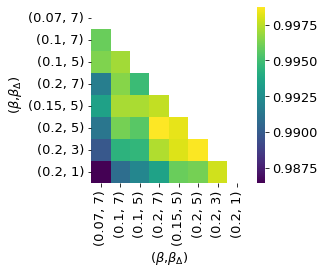

In [12]:
title='$s_i$ cosine sim.'
figname = '../figs/spreader_cos_sim_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(sim_s, 
         mu, 
         beta_betaT_range,
         r'($\beta$,$\beta_{\Delta}$)',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

# Ranking correlation

### Receiver index

In [13]:
corr_r = np.full((len(beta_betaT_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_betaT_range)-1):
    for j in range(i+1,len(beta_betaT_range)):
        corr_r[i,j] = stats.spearmanr(np.array(r_list[i]),np.array(r_list[j])).correlation

0.9026679796366198 0.9809003044677609
../figs/simplicial_rank_corr_receiver_pr_school_mu_0.10.pdf.pdf


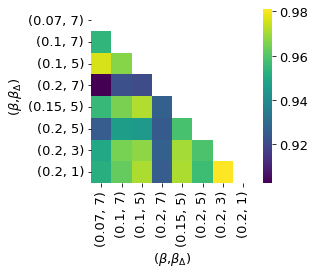

In [14]:
title='$r_i$ ranking corr.'
figname = '../figs/receiver_rank_corr_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(corr_r, 
         mu, 
         beta_betaT_range,
         r'($\beta$,$\beta_{\Delta}$)',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

### Spreader index

In [15]:
corr_s = np.full((len(beta_betaT_range),len(beta_betaT_range)),0.0)
for i in range(len(beta_betaT_range)-1):
    for j in range(i+1,len(beta_betaT_range)):
        corr_s[i,j] = stats.spearmanr(np.array(s_list[i]),np.array(s_list[j])).correlation

0.9731461054232338 0.9965927771787197
../figs/simplicial_rank_corr_spreader_pr_school_mu_0.10.pdf.pdf


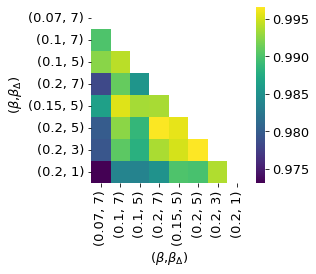

In [16]:
title='$s_i$ ranking corr.'
figname = '../figs/spreader_rank_corr_%s_mu_%.2f.pdf'%(dataset,mu)

plot_sim(corr_s, 
         mu, 
         beta_betaT_range,
         r'($\beta$,$\beta_{\Delta}$)',
         save=True, 
         figname=figname, 
         scale='independent',
         min_scale=0, 
         max_scale=1)

# Receiver vs. spreader

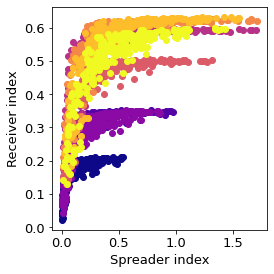

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize=(4,4))

colors = plt.cm.plasma(np.linspace(0,1,len(beta_betaT_range)))
for i in range(len(beta_betaT_range)):
    plt.plot(np.array(s_list[i]),
             np.array(r_list[i]),
             'o',
             c=colors[i],
             label=r'%.2f,%d'%(beta_betaT_range[i][0],beta_betaT_range[i][1]))
plt.xlabel('Spreader index')
plt.ylabel('Receiver index')
plt.tight_layout()
#plt.legend(title=r'$\beta$,$\beta_{\Delta}$')
plt.savefig('../figs/r_s_simplicial_%s.pdf'%dataset)
#plt.savefig('../figs/legend.pdf')

In [18]:
beta_betaT_range[0][0]

0.07